# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

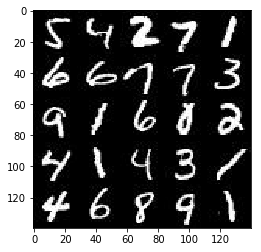

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

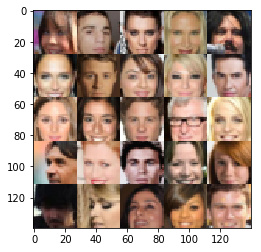

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/home/ww/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_image = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name ="input_real")
    z_data = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return real_image, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope("discriminator", reuse=reuse):
        dis_conv1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        dis_conv1 = tf.maximum(alpha*dis_conv1, dis_conv1)
        # 14x14x32
        dis_conv2 = tf.layers.conv2d(dis_conv1, 64, 5, strides=2, padding='same')
        dis_conv2 = tf.layers.batch_normalization(dis_conv2, training=True)
        dis_conv2 = tf.maximum(alpha*dis_conv2, dis_conv2)
        # 7x7x64
        
        dis_conv3 = tf.layers.conv2d(dis_conv2, 128, 5, strides=1, padding='same')
        dis_conv3 = tf.layers.batch_normalization(dis_conv3, training=True)
        dis_conv3 = tf.maximum(alpha*dis_conv3, dis_conv3)
        #7x7x128
        
        flat = tf.reshape(dis_conv3, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        de_full1 = tf.layers.dense(z, 7*7*128)
        de_full1 = tf.reshape(de_full1, (-1, 7, 7, 128))
        de_full1 = tf.layers.batch_normalization(de_full1, training=is_train)
        de_full1 = tf.maximum(alpha*de_full1, de_full1)
        #7x7x128
        
        de_conv1 = tf.layers.conv2d_transpose(de_full1, 64, 5, strides=2,padding='same')
        de_conv1 = tf.layers.batch_normalization(de_conv1, training=is_train)
        de_conv1 = tf.maximum(alpha*de_conv1, de_conv1)
        #14x14x64
        
        de_conv2 = tf.layers.conv2d_transpose(de_conv1, 32, 5, strides=2, padding='same')
        de_conv2 = tf.layers.batch_normalization(de_conv2, training=is_train)
        de_conv2 = tf.maximum(alpha*de_conv2, de_conv2)
        #28*28*32
        
        logits = tf.layers.conv2d_transpose(de_conv2, out_channel_dim, 5, strides=1, padding='same')
        #28x28x3
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real,  reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real+d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    tvars = tf.trainable_variables()
    d_vars = [var for var in tvars if var.name.startswith('discriminator')]
    g_vars = [var for var in tvars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
   
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    #print("data_shape", type(data_shape), data_shape)
    
    image_width=data_shape[1]
    image_height=data_shape[2]
    image_channels = data_shape[3]
    print("image_width:", image_width, "image_height:",image_height, 
          "image_channels:",image_channels, "data_num:",data_shape[0], "batch_num: ", data_shape[0]//batch_size)
    input_real, input_z, learningrate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learningrate, beta1)
    
    steps = 0
    print_every= 25
    show_every =  100
    losses = []
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z,learningrate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, learningrate:learning_rate})
                
                if steps % print_every ==0:
                    train_loss_d = sess.run(d_loss, feed_dict={input_real:batch_images, input_z:batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict={input_z:batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count), 
                          "Batch num {}/{}...".format(steps, data_shape[0]//batch_size),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, image_channels,data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')       
        
    return losses 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

image_width: 28 image_height: 28 image_channels: 1 data_num: 60000 batch_num:  468
Epoch 1/2... Batch num 25/468... Discriminator Loss: 2.0922... Generator Loss: 0.2895
Epoch 1/2... Batch num 50/468... Discriminator Loss: 1.3390... Generator Loss: 0.8240
Epoch 1/2... Batch num 75/468... Discriminator Loss: 1.0198... Generator Loss: 0.8672
Epoch 1/2... Batch num 100/468... Discriminator Loss: 1.0748... Generator Loss: 0.9651


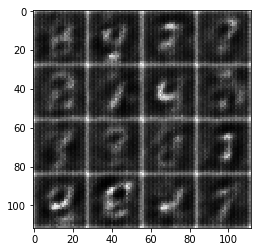

Epoch 1/2... Batch num 125/468... Discriminator Loss: 1.1978... Generator Loss: 0.7009
Epoch 1/2... Batch num 150/468... Discriminator Loss: 1.0708... Generator Loss: 0.8587
Epoch 1/2... Batch num 175/468... Discriminator Loss: 1.4745... Generator Loss: 0.3250
Epoch 1/2... Batch num 200/468... Discriminator Loss: 1.1476... Generator Loss: 1.9720


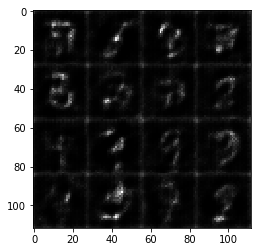

Epoch 1/2... Batch num 225/468... Discriminator Loss: 0.8377... Generator Loss: 1.1374
Epoch 1/2... Batch num 250/468... Discriminator Loss: 0.8124... Generator Loss: 0.9300
Epoch 1/2... Batch num 275/468... Discriminator Loss: 0.8082... Generator Loss: 1.0993
Epoch 1/2... Batch num 300/468... Discriminator Loss: 0.8474... Generator Loss: 0.9326


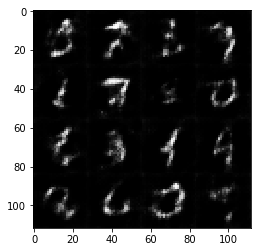

Epoch 1/2... Batch num 325/468... Discriminator Loss: 1.0654... Generator Loss: 0.6545
Epoch 1/2... Batch num 350/468... Discriminator Loss: 1.0822... Generator Loss: 0.5508
Epoch 1/2... Batch num 375/468... Discriminator Loss: 0.9278... Generator Loss: 0.8679
Epoch 1/2... Batch num 400/468... Discriminator Loss: 1.2345... Generator Loss: 0.4657


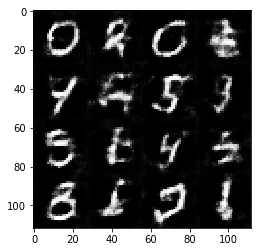

Epoch 1/2... Batch num 425/468... Discriminator Loss: 1.2017... Generator Loss: 2.0067
Epoch 1/2... Batch num 450/468... Discriminator Loss: 1.0602... Generator Loss: 0.6358
Epoch 2/2... Batch num 475/468... Discriminator Loss: 0.9788... Generator Loss: 1.3221
Epoch 2/2... Batch num 500/468... Discriminator Loss: 0.9810... Generator Loss: 1.3632


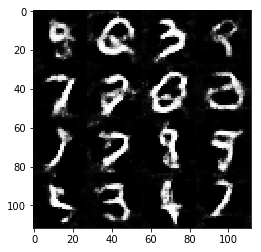

Epoch 2/2... Batch num 525/468... Discriminator Loss: 0.9622... Generator Loss: 1.3212
Epoch 2/2... Batch num 550/468... Discriminator Loss: 0.9842... Generator Loss: 1.1327
Epoch 2/2... Batch num 575/468... Discriminator Loss: 0.9553... Generator Loss: 0.8634
Epoch 2/2... Batch num 600/468... Discriminator Loss: 0.8770... Generator Loss: 1.2519


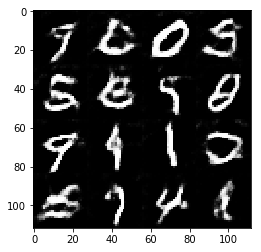

Epoch 2/2... Batch num 625/468... Discriminator Loss: 1.3115... Generator Loss: 1.3606
Epoch 2/2... Batch num 650/468... Discriminator Loss: 0.8334... Generator Loss: 0.9333
Epoch 2/2... Batch num 675/468... Discriminator Loss: 0.8787... Generator Loss: 1.1352
Epoch 2/2... Batch num 700/468... Discriminator Loss: 1.1649... Generator Loss: 0.5023


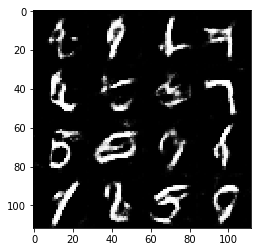

Epoch 2/2... Batch num 725/468... Discriminator Loss: 0.8196... Generator Loss: 0.9315
Epoch 2/2... Batch num 750/468... Discriminator Loss: 0.8410... Generator Loss: 1.1683
Epoch 2/2... Batch num 775/468... Discriminator Loss: 0.8890... Generator Loss: 0.7441
Epoch 2/2... Batch num 800/468... Discriminator Loss: 0.9258... Generator Loss: 0.7564


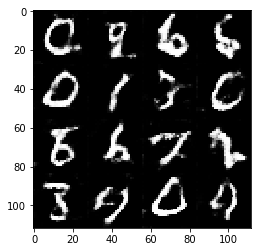

Epoch 2/2... Batch num 825/468... Discriminator Loss: 1.2202... Generator Loss: 0.5087
Epoch 2/2... Batch num 850/468... Discriminator Loss: 0.9957... Generator Loss: 1.2222
Epoch 2/2... Batch num 875/468... Discriminator Loss: 0.8023... Generator Loss: 1.0193
Epoch 2/2... Batch num 900/468... Discriminator Loss: 1.0646... Generator Loss: 0.9245


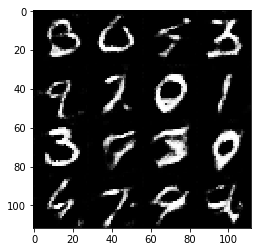

Epoch 2/2... Batch num 925/468... Discriminator Loss: 0.7790... Generator Loss: 1.0003


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

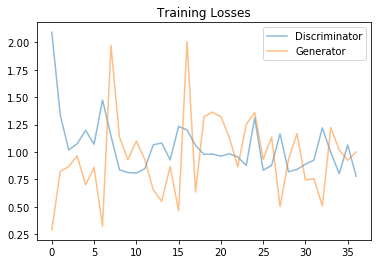

In [13]:
import matplotlib.pylab as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

image_width: 28 image_height: 28 image_channels: 3 data_num: 202599 batch_num:  1582
Epoch 1/1... Batch num 25/1582... Discriminator Loss: 0.4195... Generator Loss: 2.0793
Epoch 1/1... Batch num 50/1582... Discriminator Loss: 0.8697... Generator Loss: 1.4651
Epoch 1/1... Batch num 75/1582... Discriminator Loss: 1.7614... Generator Loss: 5.0753
Epoch 1/1... Batch num 100/1582... Discriminator Loss: 1.0176... Generator Loss: 1.2383


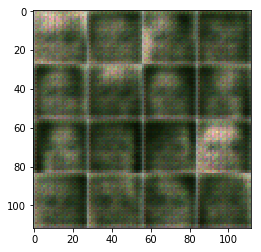

Epoch 1/1... Batch num 125/1582... Discriminator Loss: 0.4799... Generator Loss: 1.7157
Epoch 1/1... Batch num 150/1582... Discriminator Loss: 1.4198... Generator Loss: 0.3977
Epoch 1/1... Batch num 175/1582... Discriminator Loss: 0.7764... Generator Loss: 1.1797
Epoch 1/1... Batch num 200/1582... Discriminator Loss: 1.1129... Generator Loss: 0.9574


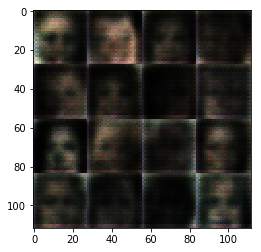

Epoch 1/1... Batch num 225/1582... Discriminator Loss: 1.7245... Generator Loss: 0.3348
Epoch 1/1... Batch num 250/1582... Discriminator Loss: 1.5647... Generator Loss: 0.3754
Epoch 1/1... Batch num 275/1582... Discriminator Loss: 1.4522... Generator Loss: 0.6225
Epoch 1/1... Batch num 300/1582... Discriminator Loss: 1.7198... Generator Loss: 0.3010


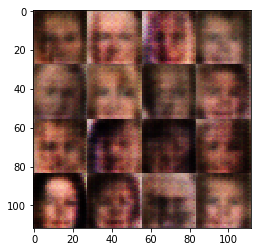

Epoch 1/1... Batch num 325/1582... Discriminator Loss: 0.4361... Generator Loss: 2.2696
Epoch 1/1... Batch num 350/1582... Discriminator Loss: 0.4802... Generator Loss: 2.1218
Epoch 1/1... Batch num 375/1582... Discriminator Loss: 0.6772... Generator Loss: 2.4123
Epoch 1/1... Batch num 400/1582... Discriminator Loss: 2.4521... Generator Loss: 0.1207


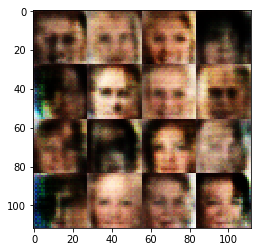

Epoch 1/1... Batch num 425/1582... Discriminator Loss: 0.9888... Generator Loss: 0.7325
Epoch 1/1... Batch num 450/1582... Discriminator Loss: 1.0417... Generator Loss: 2.7944
Epoch 1/1... Batch num 475/1582... Discriminator Loss: 1.0443... Generator Loss: 2.2931
Epoch 1/1... Batch num 500/1582... Discriminator Loss: 0.8040... Generator Loss: 1.0397


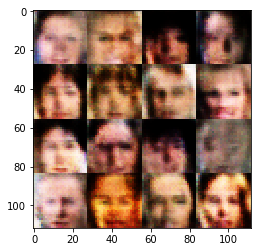

Epoch 1/1... Batch num 525/1582... Discriminator Loss: 1.0909... Generator Loss: 2.2479
Epoch 1/1... Batch num 550/1582... Discriminator Loss: 1.0514... Generator Loss: 0.6961
Epoch 1/1... Batch num 575/1582... Discriminator Loss: 0.9639... Generator Loss: 0.6971
Epoch 1/1... Batch num 600/1582... Discriminator Loss: 0.8322... Generator Loss: 0.8033


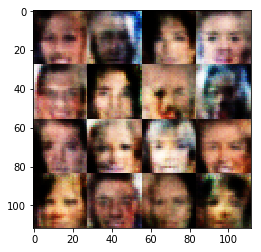

Epoch 1/1... Batch num 625/1582... Discriminator Loss: 1.0480... Generator Loss: 0.6384
Epoch 1/1... Batch num 650/1582... Discriminator Loss: 0.5026... Generator Loss: 3.0533
Epoch 1/1... Batch num 675/1582... Discriminator Loss: 1.2734... Generator Loss: 1.8189
Epoch 1/1... Batch num 700/1582... Discriminator Loss: 1.3314... Generator Loss: 0.4223


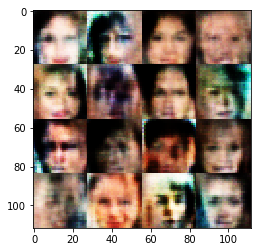

Epoch 1/1... Batch num 725/1582... Discriminator Loss: 0.9722... Generator Loss: 0.7792
Epoch 1/1... Batch num 750/1582... Discriminator Loss: 1.0905... Generator Loss: 0.5655
Epoch 1/1... Batch num 775/1582... Discriminator Loss: 0.9576... Generator Loss: 1.0035
Epoch 1/1... Batch num 800/1582... Discriminator Loss: 0.5368... Generator Loss: 1.6784


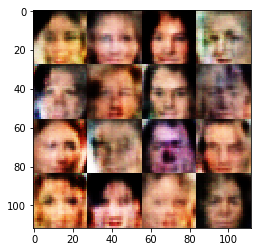

Epoch 1/1... Batch num 825/1582... Discriminator Loss: 0.5609... Generator Loss: 1.4848
Epoch 1/1... Batch num 850/1582... Discriminator Loss: 0.8331... Generator Loss: 0.8020
Epoch 1/1... Batch num 875/1582... Discriminator Loss: 0.6103... Generator Loss: 1.3846
Epoch 1/1... Batch num 900/1582... Discriminator Loss: 1.8172... Generator Loss: 0.6250


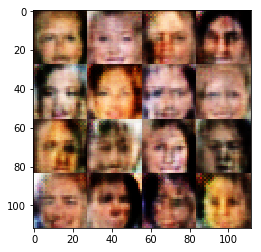

Epoch 1/1... Batch num 925/1582... Discriminator Loss: 0.7798... Generator Loss: 1.3114
Epoch 1/1... Batch num 950/1582... Discriminator Loss: 1.0382... Generator Loss: 0.5942
Epoch 1/1... Batch num 975/1582... Discriminator Loss: 0.9995... Generator Loss: 0.9431
Epoch 1/1... Batch num 1000/1582... Discriminator Loss: 0.8297... Generator Loss: 1.0156


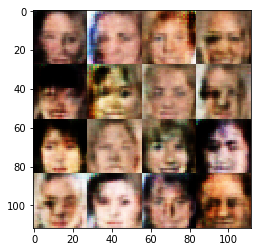

Epoch 1/1... Batch num 1025/1582... Discriminator Loss: 0.5843... Generator Loss: 1.3076
Epoch 1/1... Batch num 1050/1582... Discriminator Loss: 0.4027... Generator Loss: 1.8821
Epoch 1/1... Batch num 1075/1582... Discriminator Loss: 1.0701... Generator Loss: 0.9453
Epoch 1/1... Batch num 1100/1582... Discriminator Loss: 0.8952... Generator Loss: 0.7849


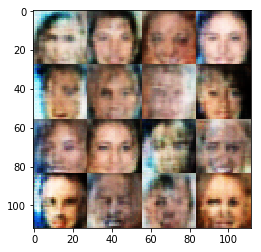

Epoch 1/1... Batch num 1125/1582... Discriminator Loss: 0.7362... Generator Loss: 1.0807
Epoch 1/1... Batch num 1150/1582... Discriminator Loss: 0.8175... Generator Loss: 2.7910
Epoch 1/1... Batch num 1175/1582... Discriminator Loss: 0.6419... Generator Loss: 1.1008
Epoch 1/1... Batch num 1200/1582... Discriminator Loss: 2.1610... Generator Loss: 0.2103


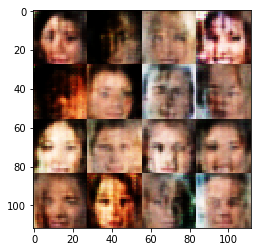

Epoch 1/1... Batch num 1225/1582... Discriminator Loss: 0.7511... Generator Loss: 0.9688
Epoch 1/1... Batch num 1250/1582... Discriminator Loss: 0.7573... Generator Loss: 1.3399
Epoch 1/1... Batch num 1275/1582... Discriminator Loss: 0.6151... Generator Loss: 1.1860
Epoch 1/1... Batch num 1300/1582... Discriminator Loss: 0.9049... Generator Loss: 0.8009


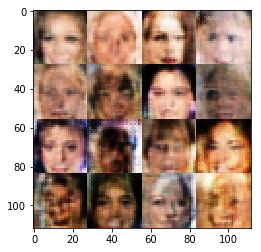

Epoch 1/1... Batch num 1325/1582... Discriminator Loss: 0.5475... Generator Loss: 2.2499
Epoch 1/1... Batch num 1350/1582... Discriminator Loss: 0.6460... Generator Loss: 1.4212
Epoch 1/1... Batch num 1375/1582... Discriminator Loss: 0.4679... Generator Loss: 1.4827
Epoch 1/1... Batch num 1400/1582... Discriminator Loss: 0.6189... Generator Loss: 1.5653


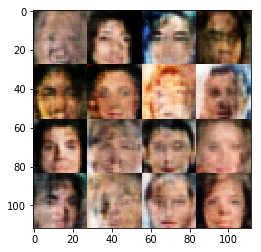

Epoch 1/1... Batch num 1425/1582... Discriminator Loss: 0.9903... Generator Loss: 1.3590
Epoch 1/1... Batch num 1450/1582... Discriminator Loss: 0.8586... Generator Loss: 0.8425
Epoch 1/1... Batch num 1475/1582... Discriminator Loss: 0.8285... Generator Loss: 1.2427
Epoch 1/1... Batch num 1500/1582... Discriminator Loss: 0.8541... Generator Loss: 0.7587


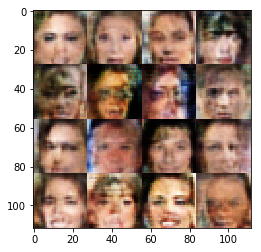

Epoch 1/1... Batch num 1525/1582... Discriminator Loss: 1.3822... Generator Loss: 1.9594
Epoch 1/1... Batch num 1550/1582... Discriminator Loss: 0.7719... Generator Loss: 0.9969
Epoch 1/1... Batch num 1575/1582... Discriminator Loss: 2.5185... Generator Loss: 3.3071


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

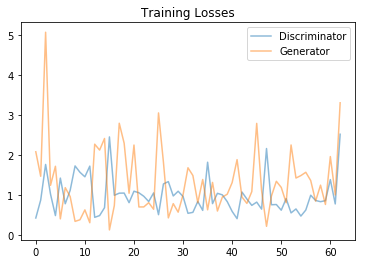

In [16]:
import matplotlib.pylab as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.